In [1]:
import os
import re
import logging
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import gensim #using gensim version 3.8.3, which might cause reproducibility issues later in the code of the model
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel  
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

import spacy

import en_core_web_sm


from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib_venn_wordcloud import venn3_wordcloud


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel


# Preparing the dataset

In [2]:
df=pd.read_csv('DataAnalyst.csv')

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:

df.loc[:, 'Job Description'] = df['Job Description'].str.replace('\n', '')

df.loc[:, 'Job Description'] = df['Job Description'].str.split('©').str.get(0)

df.loc[:, 'Job Description'] = df['Job Description'].str.lower()



C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Future topic modelling would be done on location, hence we only need them

In [4]:
dfa=df[['Job Description','Location']]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
dfa

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Job Description,Location
0,are you eager to roll up your sleeves and harn...,"New York, NY"
1,overviewprovides analytical and technical supp...,"New York, NY"
2,we’re looking for a senior data analyst who ha...,"New York, NY"
3,requisition numberrr-0001939remote:yeswe colla...,"New York, NY"
4,about fanduel groupfanduel group is a world-cl...,"New York, NY"
...,...,...
2248,maintains systems to protect data from unautho...,"Denver, CO"
2249,position:senior data analyst (corporate audit)...,"Centennial, CO"
2250,"title: technical business analyst (sql, data a...","Denver, CO"
2251,summaryresponsible for working cross-functiona...,"Centennial, CO"


In [6]:
df1=dfa

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
df1['Location']=df1['Location'].str.slice(start=-2)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
df1['Location'].value_counts()

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CA    626
TX    394
NY    345
IL    164
PA    114
AZ     97
CO     96
NC     90
NJ     86
WA     54
VA     48
OH     35
UT     33
FL     27
IN     23
DE     11
GA      4
SC      3
KS      3
Name: Location, dtype: int64

In [9]:
df_loc=df1.loc[df1['Location'].isin(['NY','CA','TX','IL','PA'])]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df_loc

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Job Description,Location
0,are you eager to roll up your sleeves and harn...,NY
1,overviewprovides analytical and technical supp...,NY
2,we’re looking for a senior data analyst who ha...,NY
3,requisition numberrr-0001939remote:yeswe colla...,NY
4,about fanduel groupfanduel group is a world-cl...,NY
...,...,...
2068,scientific business analyst (preclinical data)...,CA
2069,our client is a global leader in software serv...,CA
2070,job descriptionbelow are the job detailstitle:...,CA
2071,"at franklin templeton, we are dedicated to del...",CA


# Since only California, New York and Texas have more than 300 job descriptions, we will be using them for a better model

In [11]:
df_loc_=df_loc.loc[df_loc['Location'].isin(['TX','NY','CA'])].drop(columns=['Location'],axis=1)
df_loc_

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Job Description
0,are you eager to roll up your sleeves and harn...
1,overviewprovides analytical and technical supp...
2,we’re looking for a senior data analyst who ha...
3,requisition numberrr-0001939remote:yeswe colla...
4,about fanduel groupfanduel group is a world-cl...
...,...
2068,scientific business analyst (preclinical data)...
2069,our client is a global leader in software serv...
2070,job descriptionbelow are the job detailstitle:...
2071,"at franklin templeton, we are dedicated to del..."


# Tokenizing, cleaning, stemming etc

In [12]:
DOCS = [abstract.strip().lower() for abstract in df_loc_['Job Description']]

# hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
DOCS[393]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'data analystonline retailertorrence caour client is currently seeking an outstanding data analyst with extensive data analytics experience to work in the newly built data science team. the candidate will be responsible for analyses of large amount of data from different scopes of business, developing new dashboards and improving existing reports. the role involves a tight collaboration with many departments including supply chain, it, pricing, merchandising and c_level managers. the ideal candidate is a highly data_driven individual with great communication skills.you willdevelop forward_thinking strategies for gross margin optimization;use statistical methods to analyze data and generate useful business reports;identify and recommend new ways to cost optimization by streamlining business processes;continually evaluate sales data and develop data_driven decisions;work with other departments to outline specific data needs for each business method;develop and maintain reporting that ada

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


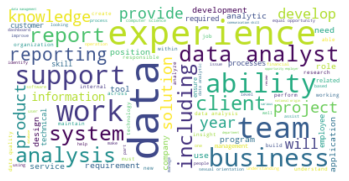

<Figure size 432x288 with 0 Axes>

In [14]:
#word cloud to visualize the words in our corpus

#have all the strings in the list as one
KK=" ".join(DOCS) 

#visualize
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(KK)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('wordcloud.jpeg')

In [15]:
nlp = en_core_web_sm.load()

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# send output to the screen
LINE = ''.join(['\n', 79 * '-', '\n'])

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
MY_STOPWORDS=['eager', 'roll', 'sleeve', 'drive', 'policy', 'change', 'enjoy', 'sift', 'complex', 'illuminate', 'trend', 'work',
'organization', 'tackle', 'pressing', 'injustice', 'day?we', 'look', 'hire', 'bright', 'hard_working', 'creative',
'individual', 'strong', 'demonstrated', 'commitement', 'imigrant', 'right', 'assist', 'reporting', 'need', 'vera', 
'center', 'immigration', 'justice', 'current', 'project', 'future', 'initiatives.who', 'found', 'institute', 
 'independent', 'non_partisan', 'nonprofit', 'combine', 'assistance', 'demonstration', 'civil', 'society', 'examine',
'improve', 'people', 'rely', 'safety.we', 'study', 'impede', 'human', 'dignity', 'justice.we', 'pilot', 
'transformative', 'achievable.we', 'engage', 'diverse', 'community', 'inform', 'debate.and', 'harnes', 'practicewhat',
'help', 'movementamong', 'advocate', 'legal', 'service', 'communitytoward', 'universal', 'respresentation', 'face', 'deportation',
'enforcement', 'million', 'partner', 'opportunity', 'position', 'duty', 'orientation', 'role', 'report', 'member', 
'responsibility', 'include', 'performance', 'process', 'new', 'communicate', 'deliver', 'training', 'maintain', 
'quality', 'issue', 'applicant', 'experience', 'year', 'multiple', 'require', 'requirement', 'application', 
'equal', 'employer', 'disability', 'internal', 'external', 'improvement', 'relate', 'collaborate', 'operation', 
'development', 'identify', 'review', 'procedure', 'ensure', 'perform', 'degree', 'communication', 'diversity', 
 'employee', 'company', 'candidate', 'demonstrate', 'understanding', 'way', 'life', 'learn', 'benefit', 'work','skills','team','experience', 'work', 'skills', 'team', 'ability', 'years', 'the', 'knowledge', 'support', 'job', 'requirements', 'we', 'strong', 'reporting', 'required', 'quality', 'working', 'including', 'tools', 'development', 'reports', 'new', 'technical', 'solutions', 'degree', 'provide', 'related', 'preferred', 'position', 'company', 'using', 'develop', 'must' 'role', 'processes', 'process', 'project', 'this', 'technology', 'opportunity', 'services', 'status', 'complex', 'teams', 'responsibilities', 'projects', 'across', 'you', 'performance', 'understanding', 'needs', 'help', 'ensure', 'identity', 'key', 'time', 'employment', 'use', '+', 'and/or', 'school']

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# expand on spaCy's stopwords 
MY_STOPWORDS=[]

for i in DOCS_TOKENS:
    for word in i:
        if word in MY_STOPWORDS:
            i.remove(word)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#DOCS_TOKENS

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in', u'and',]

# find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=COMMON_TERMS)


DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# check nlp pipeline
#print('',
#      'Job description:', DOCS[0],
#      'Tokenized Job description:', DOCS_TOKENS[0],
#      'Tri-grammed tokenised job description:', DOCS_PHRASED[0],
#      sep=LINE, end=LINE)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#for model to work this part needs to be changed. Only works with gensim 3.8.3
MALLET_PATH = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/bin/mallet' 

import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/'

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Building a model

In [24]:
#for model to work this part needs to be changed. Only works with gensim 3.8.3
N_TOPICS = 18
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=5)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.147*"datum" + 0.037*"data" + 0.036*"database" + 0.036*"analyze" + 0.026*"experience"'),
 (1,
  '0.033*"reporting" + 0.028*"report" + 0.024*"analysis" + 0.024*"experience" + 0.022*"financial"'),
 (2,
  '0.037*"team" + 0.020*"product" + 0.018*"datum" + 0.016*"build" + 0.013*"customer"'),
 (3,
  '0.036*"datum" + 0.020*"analytic" + 0.017*"solution" + 0.016*"support" + 0.014*"security"'),
 (4,
  '0.030*"product" + 0.024*"team" + 0.024*"marketing" + 0.022*"company" + 0.013*"medium"'),
 (5,
  '0.039*"research" + 0.034*"analysis" + 0.017*"statistical" + 0.016*"experience" + 0.014*"datum"'),
 (6,
  '0.051*"ability" + 0.025*"skill" + 0.018*"require" + 0.017*"perform" + 0.017*"work"'),
 (7,
  '0.030*"disability" + 0.018*"national_origin" + 0.016*"age" + 0.016*"status" + 0.015*"employment"'),
 (8,
  '0.068*"business" + 0.030*"requirement" + 0.026*"solution" + 0.025*"datum" + 0.024*"technical"'),
 (9,
  '0.032*"year" + 0.025*"job" + 0.020*"analyst" + 0.020*"skill" + 0.019*"work"'),
 (10,


# Visualization of topic modelling

In [25]:
pyLDAvis.enable_notebook()


model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)
LDAvis_prepared = gensimvis.prepare(model,CORPUS,DICT)

LDAvis_prepared

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.111333  0.244924       1        1  6.590736
6     -0.091747 -0.105698       2        1  6.531792
2      0.163703  0.241293       3        1  6.425543
17    -0.079043 -0.247494       4        1  6.392654
8     -0.090772  0.057814       5        1  6.384870
16    -0.126184  0.060454       6        1  5.988501
13     0.296726 -0.045129       7        1  5.877460
7      0.113755 -0.253853       8        1  5.615952
5     -0.129370 -0.075001       9        1  5.544641
1     -0.139384 -0.010282      10        1  5.448293
4      0.237324  0.105262      11        1  5.338190
12     0.146291  0.076662      12        1  5.282929
0     -0.219729  0.102803      13        1  4.990037
11     0.096127 -0.045002      14        1  4.979766
14    -0.070062 -0.031731      15        1  4.959677
3     -0.048470 -0.060434      16        1  4.946930
15    -0.025857  0.103770      17        1  4.540647
9      0.078025 -0.118360      18        1  4.161383, topic_info=            Term         Freq        Total Category  logprob  loglift
89         datum  9842.000000  9842.000000  Default  30.0000  30.0000
407     business  4261.000000  4261.000000  Default  29.0000  29.0000
83          data  3787.000000  3787.000000  Default  28.0000  28.0000
3        ability  1623.000000  1623.000000  Default  27.0000  27.0000
16      analysis  2470.000000  2470.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
278      quality   101.960632  1235.159948  Topic18  -5.0116   0.6850
306         role    97.756070   912.601370  Topic18  -5.0537   0.9455
1168        high    91.449227   513.306432  Topic18  -5.1204   1.4542
166      include    94.602649  1852.847749  Topic18  -5.0865   0.2045
872   technology    88.295805  1219.526584  Topic18  -5.1555   0.5538

[1757 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1386      11  0.069139             $
1386      16  0.099387             $
1386      17  0.095066             $
1386      18  0.734599             $
706       18  1.001045             +
...      ...       ...           ...
898        1  0.986354  you!celerity
899       17  0.948513          you•
15439      5  0.993804            zs
4889      18  0.998915             |
5585      10  0.997653             ●

[3056 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 3, 18, 9, 17, 14, 8, 6, 2, 5, 13, 1, 12, 15, 4, 16, 10])

# find coherence (runs long time)

# CA ONLY

In [26]:
df_loc_ca=df_loc.loc[df_loc['Location'].isin(['CA'])].drop(columns=['Location'],axis=1)
df_loc_ca

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Job Description
454,ref id: 00310-0011482030classification: sales ...
455,about the employernestled close to the majesti...
456,the purpose of the data analyst in the case in...
513,the product strategy group works to ensure the...
514,about the lead data analyst at headspace:heads...
...,...
2068,scientific business analyst (preclinical data)...
2069,our client is a global leader in software serv...
2070,job descriptionbelow are the job detailstitle:...
2071,"at franklin templeton, we are dedicated to del..."


In [27]:
DOCS = [abstract.strip().lower() for abstract in df_loc_ca['Job Description']]

# hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
DOCS[1]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'about the employernestled close to the majestic sierra mountains in the heart of california\'s san joaquin valley, the visalia unified school district is committed to providing students young and old with the tools and skills necessary to succeed in life.established in 1885, vusd is the oldest school district in tulare county. our services span 214 square miles with a population base of over 135,000. our family of schools includes 26 elementary schools, a newcomer language center, five middle schools, four comprehensive high schools, a continuation high school, an adult school,a charter independent study school, a k_8 charter home school, and a charter technical early college high school. over 32,000 students pre_k to adult are served through visalia unified school district.our outstanding workforce is comprised of over 3,000 certificated and classified staff. they make our district the jewel of the central valley. our district motto is "we create futures".job informationdate posted:7

In [29]:
%matplotlib inline

# send output to the screen
LINE = ''.join(['\n', 79 * '-', '\n'])

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# expand on spaCy's stopwords 
MY_STOPWORDS=[]

for i in DOCS_TOKENS:
    for word in i:
        if word in MY_STOPWORDS:
            i.remove(word)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in', u'and',]

# find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=COMMON_TERMS)


DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# check nlp pipeline
#print('',
#      'Job description:', DOCS[0],
#      'Tokenized job description:', DOCS_TOKENS[0],
#      'Tri-grammed tokenised job description:', DOCS_PHRASED[0],
#      sep=LINE, end=LINE)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
MALLET_PATH = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/bin/mallet'

import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/'

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
N_TOPICS = 12
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=5)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.029*"ability" + 0.026*"report" + 0.015*"knowledge" + 0.015*"skill" + 0.014*"require"'),
 (1,
  '0.028*"experience" + 0.024*"client" + 0.023*"strong" + 0.022*"datum" + 0.018*"skill"'),
 (2,
  '0.051*"business" + 0.026*"project" + 0.023*"solution" + 0.022*"requirement" + 0.021*"datum"'),
 (3,
  '0.031*"datum" + 0.023*"work" + 0.019*"product" + 0.019*"marketing" + 0.015*"team"'),
 (4,
  '0.017*"work" + 0.017*"position" + 0.015*"employee" + 0.014*"program" + 0.014*"information"'),
 (5,
  '0.027*"team" + 0.025*"company" + 0.019*"product" + 0.017*"opportunity" + 0.016*"people"'),
 (6,
  '0.123*"datum" + 0.033*"database" + 0.033*"analyze" + 0.023*"information" + 0.022*"experience"'),
 (7,
  '0.037*"analytic" + 0.034*"business" + 0.031*"insight" + 0.031*"datum" + 0.022*"analysis"'),
 (8,
  '0.031*"health" + 0.028*"research" + 0.020*"analysis" + 0.015*"work" + 0.014*"experience"'),
 (9,
  '0.076*"datum" + 0.020*"data" + 0.020*"analyst" + 0.019*"report" + 0.017*"tool"'),
 (10,
  '0.018

In [36]:
pyLDAvis.enable_notebook()


model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)
LDAvis_prepared = gensimvis.prepare(model,CORPUS,DICT)

LDAvis_prepared

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.066674  0.264137       1        1  9.990079
2      0.052121 -0.033980       2        1  9.894399
0      0.144152 -0.100618       3        1  9.037371
5     -0.260057  0.117715       4        1  8.573899
11     0.078278 -0.171509       5        1  8.345875
3     -0.154408  0.140635       6        1  8.322922
4     -0.094939 -0.296159       7        1  8.255247
10    -0.286431 -0.025777       8        1  8.199838
9      0.156540  0.083263       9        1  7.772360
8      0.064980 -0.077600      10        1  7.497655
6      0.226712  0.092079      11        1  7.249115
1      0.006377  0.007815      12        1  6.861240, topic_info=            Term         Freq        Total Category  logprob  loglift
48         datum  4443.000000  4443.000000  Default  30.0000  30.0000
31      business  1911.000000  1911.000000  Default  29.0000  29.0000
14      analytic   777.000000   777.000000  Default  28.0000  28.0000
115       report   833.000000   833.000000  Default  27.0000  27.0000
695      insight   521.000000   521.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
14      analytic    72.448328   777.870065  Topic12  -5.0586   0.3056
121       review    60.898594   246.290734  Topic12  -5.2322   1.2820
984      deliver    59.848618   235.851064  Topic12  -5.2496   1.3079
73       include    65.098497   761.412519  Topic12  -5.1655   0.2200
671  environment    60.898594   311.228618  Topic12  -5.2322   1.0480

[1123 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
401       4  0.864596                  +
401       8  0.008006                  +
401      12  0.128088                  +
1384      1  0.707472  +_year_experience
1384     12  0.293873  +_year_experience
...     ...       ...                ...
399      12  0.952403              young
6119      2  0.986039                 zs
4965     12  1.000023                  |
400       4  0.989556                  ®
2763      6  0.998135                  ●

[1637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 1, 6, 12, 4, 5, 11, 10, 9, 7, 2])

# Texas only

In [37]:
df_loc_tx=df_loc.loc[df_loc['Location'].isin(['TX'])].drop(columns=['Location'],axis=1)
df_loc_tx

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Job Description
884,smith is an entrepreneurial company with globa...
885,monitors and manages large volumes of transact...
886,smith is an entrepreneurial company with globa...
887,we are seeking a talented data specialist to j...
888,"company summaryat crown castle, we work around..."
...,...
1755,"""join one of the fastest growing company"" sm l..."
1756,"job description""join one of the fastest growin..."
1757,primary duties & key responsibilities(primary ...
1758,duration & type: 6+ months contract with a pha...


In [38]:
DOCS = [abstract.strip().lower() for abstract in df_loc_tx['Job Description']]

# hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
DOCS[1]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"monitors and manages large volumes of transactions, updates data in systems and performs reconciliations on a daily basis. assists with various tasks related to deal management. communicates with internal and external parties, regarding deal_specific items.required skillseducation/training (or equivalent):* bachelor's degree requiredexperience (type of work experience, minimum number of years):* minimum 3 years experience in accounting or financetechnical or administrative knowledge:* highly proficient in microsoft suite* basic bloomberg knowledge desired* basic knowledge of securitiesspecial skills and/or abilities:* excellent analytical and problem_solving skills* strong verbal and written communication skills* excellent attention to detail* exercises independent judgment and multi_task oriented* takes initiative and ownership of job responsibilities* must be able to work well in a team environment* must be able to perform essential job duties accurately and timely* must adhere to d

In [40]:
# send output to the screen
LINE = ''.join(['\n', 79 * '-', '\n'])

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:

# expand on spaCy's stopwords 

MY_STOPWORDS=[]

for i in DOCS_TOKENS:
    for word in i:
        if word in MY_STOPWORDS:
            i.remove(word)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in', u'and',]

# find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=COMMON_TERMS)


DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# check nlp pipeline
#print('',
#      'Job description:', DOCS[0],
#      'Tokenized job description:', DOCS_TOKENS[0],
#      'Tri-grammed tokenised job description:', DOCS_PHRASED[0],
#      sep=LINE, end=LINE)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
MALLET_PATH = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/bin/mallet'

import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/'

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
N_TOPICS = 10
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=5)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.030*"datum" + 0.021*"technology" + 0.019*"work" + 0.017*"solution" + 0.016*"development"'),
 (1,
  '0.049*"datum" + 0.028*"experience" + 0.021*"analysis" + 0.016*"analyst" + 0.015*"healthcare"'),
 (2,
  '0.083*"datum" + 0.019*"analysis" + 0.019*"data" + 0.018*"research" + 0.016*"database"'),
 (3,
  '0.073*"datum" + 0.037*"data" + 0.032*"business" + 0.018*"management" + 0.017*"requirement"'),
 (4,
  '0.020*"work" + 0.019*"company" + 0.016*"people" + 0.014*"build" + 0.014*"client"'),
 (5,
  '0.025*"work" + 0.022*"experience" + 0.018*"position" + 0.016*"system" + 0.016*"level"'),
 (6, '0.034*"team" + 0.025*"work" + 0.024*"job" + 0.019*"sql" + 0.019*"test"'),
 (7,
  '0.020*"skill" + 0.018*"ability" + 0.018*"datum" + 0.015*"knowledge" + 0.015*"require"'),
 (8,
  '0.021*"information" + 0.020*"disability" + 0.016*"status" + 0.014*"provide" + 0.013*"business"'),
 (9,
  '0.032*"analytic" + 0.024*"business" + 0.022*"analysis" + 0.018*"reporting" + 0.017*"report"')]

In [47]:
pyLDAvis.enable_notebook()


model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)
LDAvis_prepared = gensimvis.prepare(model,CORPUS,DICT)

LDAvis_prepared

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.174749  0.202506       1        1  11.088817
3      0.108637  0.040396       2        1  11.055387
2      0.189979  0.031785       3        1  10.279761
4     -0.369264  0.192883       4        1  10.102259
7     -0.012681 -0.128993       5        1   9.978395
5     -0.020271 -0.227082       6        1   9.944487
8     -0.092140 -0.227750       7        1   9.817780
1      0.125815  0.024430       8        1   9.757287
0     -0.053337  0.086210       9        1   9.542136
6     -0.051487  0.005615      10        1   8.433691, topic_info=           Term         Freq        Total Category  logprob  loglift
41        datum  2808.000000  2808.000000  Default  30.0000  30.0000
39         data   852.000000   852.000000  Default  29.0000  29.0000
559    analytic   408.000000   408.000000  Default  28.0000  28.0000
6      analysis   746.000000   746.000000  Default  27.0000  27.0000
249        team   684.000000   684.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
146     support    84.760539   587.510973  Topic10  -4.6735   0.5369
246      system    79.592213   593.211658  Topic10  -4.7364   0.4643
730        lead    65.120902   179.144548  Topic10  -4.9371   1.4610
77     identify    67.188232   265.231700  Topic10  -4.9058   1.0998
8    analytical    65.120902   282.741422  Topic10  -4.9371   1.0046

[868 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1386      7  0.801459                  +
1386     10  0.205024                  +
1984      4  0.317064  +_year_experience
1984     10  0.681688  +_year_experience
0         1  0.275944            ability
...     ...       ...                ...
164      10  0.165522              write
165       3  0.093438               year
165       6  0.478402               year
165       9  0.429814               year
7003      8  1.030127                  ®

[1221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 3, 5, 8, 6, 9, 2, 1, 7])

# New York only

In [48]:
df_loc_ny=df_loc.loc[df_loc['Location'].isin(['NY'])].drop(columns=['Location'],axis=1)
df_loc_ny

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Job Description
0,are you eager to roll up your sleeves and harn...
1,overviewprovides analytical and technical supp...
2,we’re looking for a senior data analyst who ha...
3,requisition numberrr-0001939remote:yeswe colla...
4,about fanduel groupfanduel group is a world-cl...
...,...
410,technology architecture and data is the enterp...
415,"praescient analytics, llc (praescient) is a ve..."
416,overviewrole: senior data analystlocation: bro...
417,position overviewthe senior billing data analy...


In [49]:
DOCS = [abstract.strip().lower() for abstract in df_loc_ny['Job Description']]

# hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
DOCS[1]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'overviewprovides analytical and technical support for the integration of multiple data sources used to prepare internal and external reporting for the quality management team and business stakeholders. provides support and analytical insight for quality incentive measures, hedis measures, and quality improvement initiatives. monitors, analyzes, and communicates quality performance related to benchmarks. collaborates with clinical and operational teams within quality management, as well as with choice clinical operations and business intelligence & analytics (bia). participates in data validation of current reporting and dashboards. monitors data integrity of databases and provides recommendation accordingly. participates in the development of internal dashboards and databases. works under general direction.responsibilitiesprovides support and analytical insight for quality incentive measures, hedis measures, and quality improvement initiatives.monitors internal performance against ben

In [51]:
# send output to the screen
LINE = ''.join(['\n', 79 * '-', '\n'])

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# expand on spaCy's stopwords 
MY_STOPWORDS=[]

for i in DOCS_TOKENS:
    for word in i:
        if word in MY_STOPWORDS:
            i.remove(word)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in', u'and',]

# find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=COMMON_TERMS)

DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# check nlp pipeline
#print('',
#      'Job description:', DOCS[0],
#      'Tokenized job description:', DOCS_TOKENS[0],
#      'Tri-grammed tokenised job description:', DOCS_PHRASED[0],
#      sep=LINE, end=LINE)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
MALLET_PATH = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/bin/mallet'

import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:/Users/ibulf/Desktop/nlp/hac2/mallet-2.0.8/'

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
N_TOPICS = 14 #best number based on 
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=5)

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.042*"business" + 0.040*"analysis" + 0.021*"product" + 0.018*"team" + 0.017*"process"'),
 (1,
  '0.035*"datum" + 0.027*"analysis" + 0.024*"report" + 0.023*"include" + 0.018*"program"'),
 (2,
  '0.024*"team" + 0.024*"financial" + 0.023*"work" + 0.023*"company" + 0.019*"product"'),
 (3,
  '0.034*"sql" + 0.028*"datum" + 0.027*"experience" + 0.027*"database" + 0.016*"maintain"'),
 (4,
  '0.028*"management" + 0.021*"support" + 0.018*"include" + 0.018*"market" + 0.018*"system"'),
 (5,
  '0.043*"business" + 0.037*"requirement" + 0.026*"datum" + 0.026*"development" + 0.022*"technical"'),
 (6,
  '0.030*"analytic" + 0.026*"datum" + 0.017*"support" + 0.014*"provide" + 0.012*"solution"'),
 (7,
  '0.043*"datum" + 0.026*"health" + 0.020*"healthcare" + 0.017*"tool" + 0.017*"work"'),
 (8,
  '0.039*"datum" + 0.028*"analytic" + 0.025*"team" + 0.019*"insight" + 0.013*"build"'),
 (9,
  '0.021*"disability" + 0.020*"employment" + 0.018*"status" + 0.014*"protect" + 0.013*"age"'),
 (10,
  '0.137*"dat

In [58]:
pyLDAvis.enable_notebook()


model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)
LDAvis_prepared = gensimvis.prepare(model,CORPUS,DICT)


pyLDAvis.save_html(LDAvis_prepared, 'lda.html') 
LDAvis_prepared


C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.064545  0.124917       1        1  8.107737
9      0.043667  0.291693       2        1  8.024158
0      0.084458  0.072037       3        1  7.659339
11     0.200966  0.029599       4        1  7.531441
8      0.044813 -0.163798       5        1  7.432152
1     -0.204515  0.052311       6        1  7.313812
13    -0.088725 -0.182309       7        1  7.136835
2      0.269718 -0.038225       8        1  7.127962
7     -0.088292 -0.143443       9        1  7.109013
5     -0.067963 -0.052242      10        1  6.880658
12     0.202907 -0.062534      11        1  6.815954
4     -0.101772  0.195985      12        1  6.318840
3     -0.131199  0.014342      13        1  6.285236
10    -0.099519 -0.138332      14        1  6.256865, topic_info=           Term         Freq        Total Category  logprob  loglift
92        datum  2616.000000  2616.000000  Default  30.0000  30.0000
411    business   979.000000   979.000000  Default  29.0000  29.0000
85         data   788.000000   788.000000  Default  28.0000  28.0000
18     analysis   539.000000   539.000000  Default  27.0000  27.0000
397    analytic   550.000000   550.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
411    business    63.658487   979.658547  Topic14  -4.5364   0.0378
735      client    48.804840   419.796426  Topic14  -4.8021   0.6196
45       change    32.890218   113.427311  Topic14  -5.1967   1.5335
208  management    40.317042   520.182996  Topic14  -4.9931   0.2141
620        good    33.951193   179.094777  Topic14  -5.1650   1.1085

[1252 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1386      1  0.305705                $
1386      8  0.696329                $
710       3  0.101022           +_year
710       5  0.330004           +_year
710       7  0.033674           +_year
...     ...       ...              ...
562      12  0.655707  year_experience
386       5  0.971275        years.how
900      11  0.939829     you!celerity
387       5  0.971275            youre
5541      3  1.004807                ●

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 1, 12, 9, 2, 14, 3, 8, 6, 13, 5, 4, 11])

# Assigning labels to topics of models for each state
visualizing it using venn diagram

C:\Users\ibulf\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\ibulf\anaconda3\lib\site-packages\matplotlib_venn_wordcloud\_main.py:519: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.rgba = np.zeros((self.y_resolution, self.x_resolution, 4), dtype=np.float)


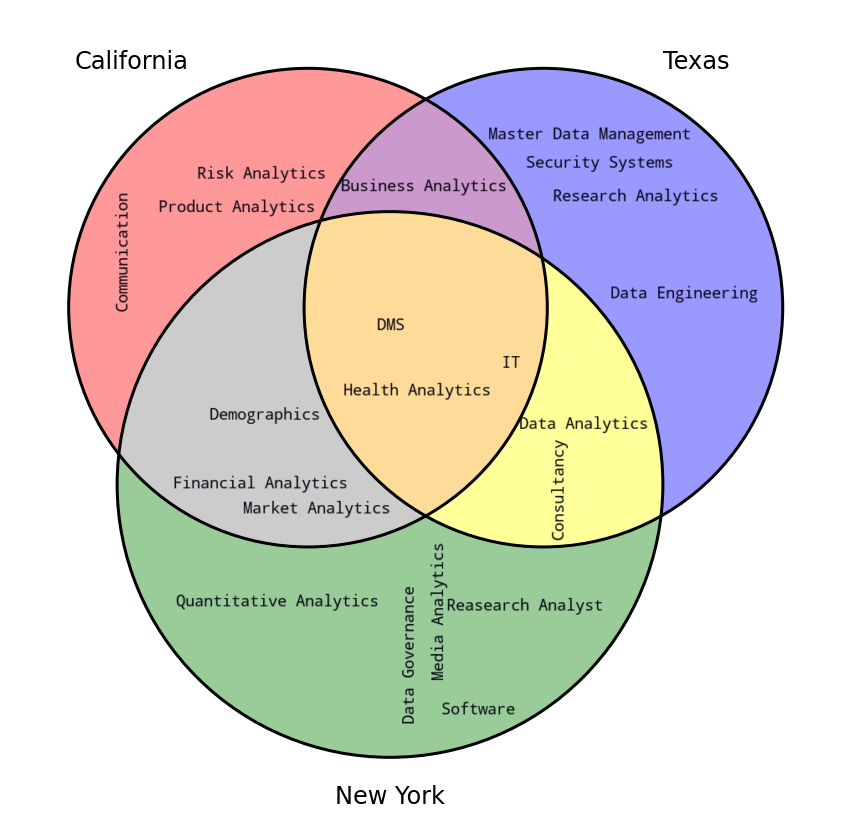

In [59]:
fig, ax = plt.subplots(figsize=(15,15))

#labels of topics for each state
cali = set(['Risk Analytics', 'IT', 'DMS' , 'Communication', 'Health Analytics', 'Demographics', 
           'Business Analytics', 'Financial Analytics' , 'Market Analytics' , 'Product Analytics'
          ])

texas = set(['Business Analytics', 'Consultancy', 'Research Analytics' , 'Data Analytics', 'DMS', 'Data Engineering', 
           'Health Analytics', 'Master Data Management' , 'Security Systems' , 'IT'
          ])

ny = set(['Market Analytics', 'Software' , 'Media Analytics', 'DMS', 'Demographics', 
           'Health Analytics', 'Consultancy' , 'Financial Analytics' , 'IT' , ' Quantitative Analytics',
      'Data Governance', 'Reasearch Analyst', 'Data Analytics',
          ])

#making of venn diagram
v = venn3_wordcloud([cali, texas, ny], ('California', 'Texas', 'New York'),ax=ax)

#altering the color and tranparency of each section
v.get_patch_by_id('100').set_color('red')
v.get_patch_by_id('100').set_alpha(0.4)

v.get_patch_by_id('010').set_color('blue')
v.get_patch_by_id('010').set_alpha(0.4)

v.get_patch_by_id('110').set_color('purple')
v.get_patch_by_id('110').set_alpha(0.4)

v.get_patch_by_id('001').set_color('green')
v.get_patch_by_id('001').set_alpha(0.4)

v.get_patch_by_id('101').set_color('grey')
v.get_patch_by_id('101').set_alpha(0.4)

v.get_patch_by_id('011').set_color('yellow')
v.get_patch_by_id('011').set_alpha(0.4)

v.get_patch_by_id('111').set_color('orange')
v.get_patch_by_id('111').set_alpha(0.4)


plt.show()